<a href="https://colab.research.google.com/github/KevinWuWorld/BaltimoreOrioles3DCV/blob/main/bat_dimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import glob
import os

from google.colab import files

In [ ]:
%cd /content/
!mkdir -p /content/data/bats
%cd /content/data/bats
uploaded = files.upload()
dir = os.getcwd()

/content
/content/data/bats


# Camera Calibration

In [93]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import os
import glob

from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

images = glob.glob('/content/drive/MyDrive/test_images/*.jpg')
print("number of jpg files loaded:",len(images))
print(images[-1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
number of jpg files loaded: 21
/content/drive/MyDrive/test_images/actual_bat_take11.jpg


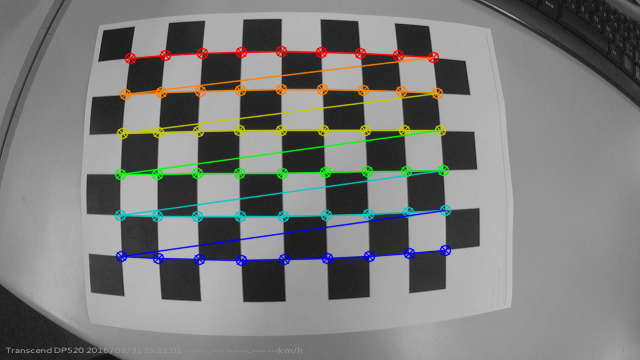

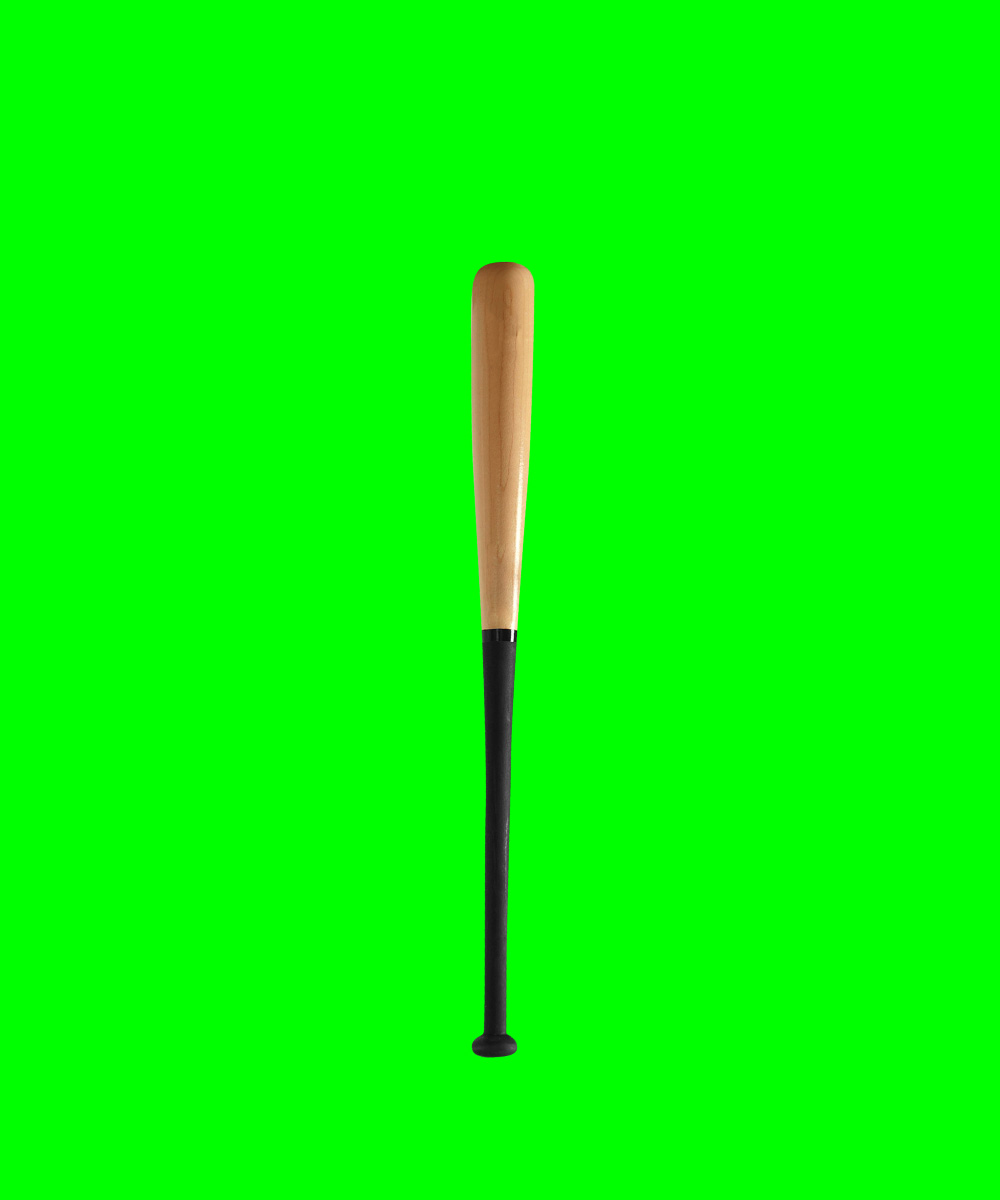

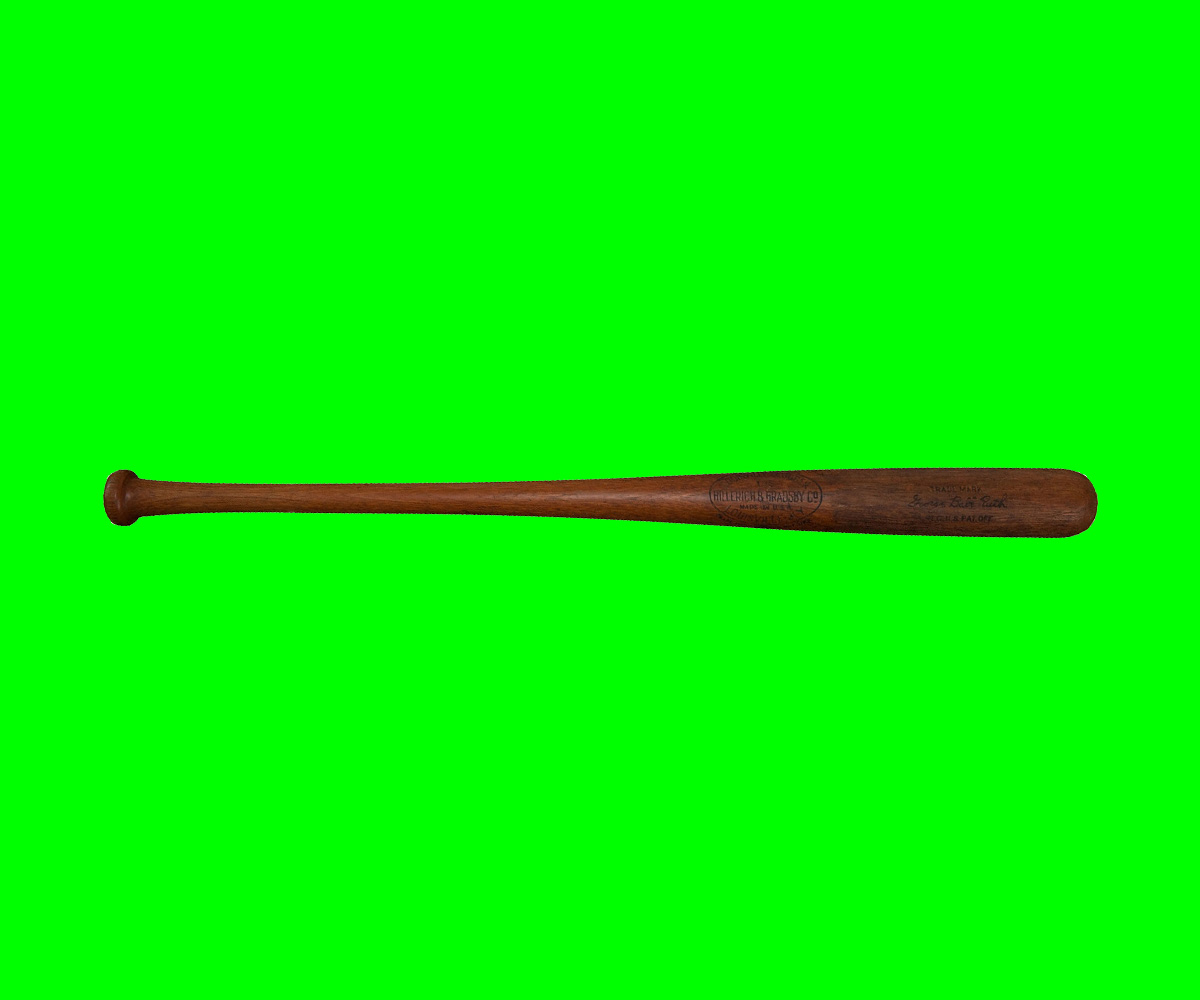

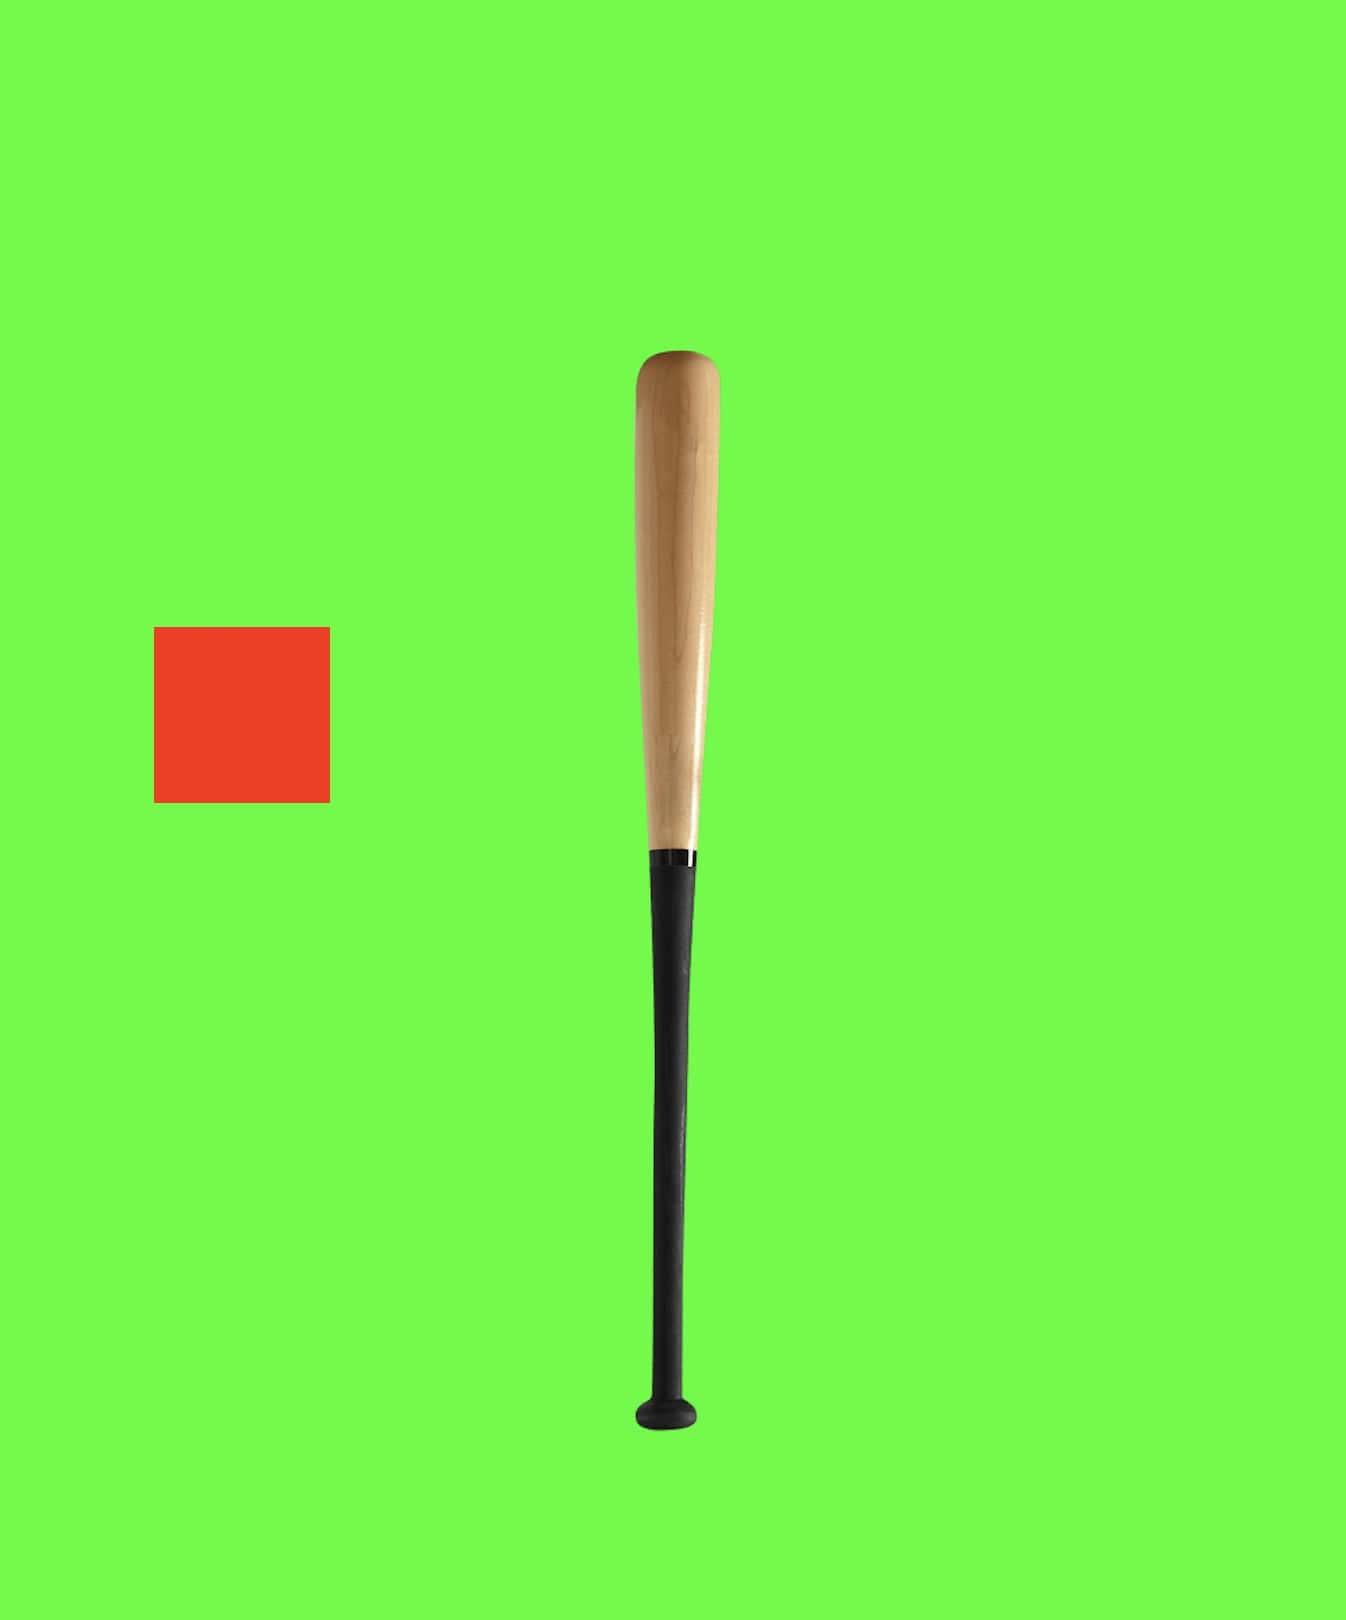

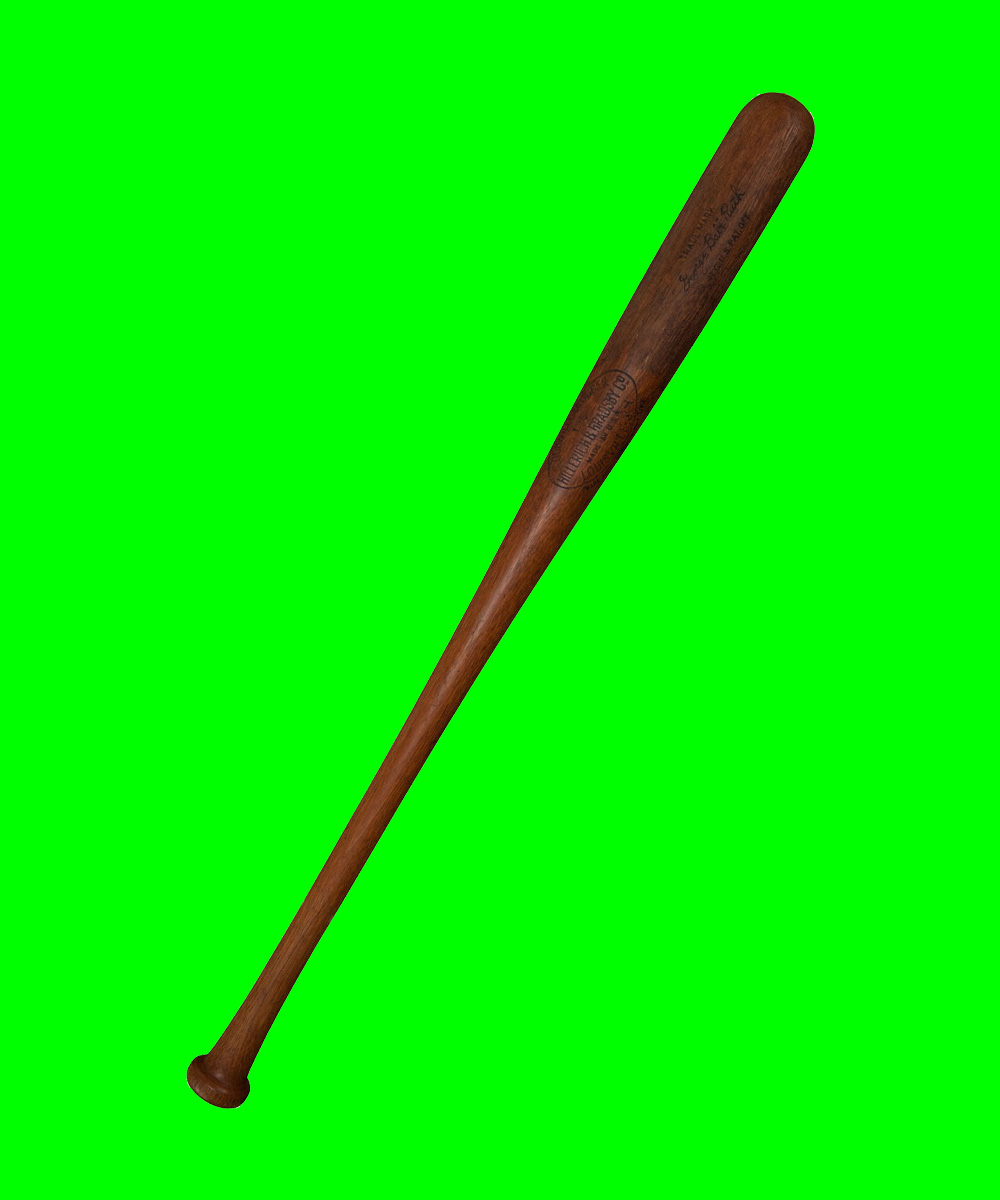

KeyboardInterrupt: 

In [57]:
# Defining the dimensions of checkerboard
CHECKERBOARD = (9,6)      # subject to change later on!
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = []


# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

# Extracting path of individual image stored in a given directory

# lines below have been moved to the section above, the set-up section
# images = glob.glob('/content/drive/MyDrive/test_images/*.jpg')
# print(len(images))


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    """
    If desired number of corner are detected,
    we refine the pixel coordinates and display
    them on the images of checker board
    """
    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        # (11,11) is the search window size to determine the accurate locations
        # of board corners; (11,11) is a commonly used size; larger size would
        # exponentially slow down the program.


        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)

    cv2_imshow(img)
    cv2.waitKey(0)

cv2.destroyAllWindows()

# acquiring the height & width of the img
h,w = img.shape[:2]

"""
Performing camera calibration by
passing the value of known 3D points (objpoints)
and corresponding pixel coordinates of the
detected corners (imgpoints)
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)


# new_img = cv2.imread('/content/drive/MyDrive/test_images/*.jpg')

# which alpha to choose here? 0 or 1?
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# which undistortion method to use? can experiment with trial and error...

# ---------- undistort method 1 below --------------
# dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# # dst = cv2.undistort(img, mtx, dist, None, mtx)

# # crop the image
# x, y, w, h = roi
# dst = dst[y:y+h, x:x+w]
# cv2.imwrite('calibresult.png', dst)
# cv2_imshow(dst)

# ---------- undistort method 2 below --------------
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
img = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

x, y, w, h = roi
img = img[y:y + h, x:x + w]
cv2_imshow(img)


# Object Detection

#Approach 1: Histogram Thresholding

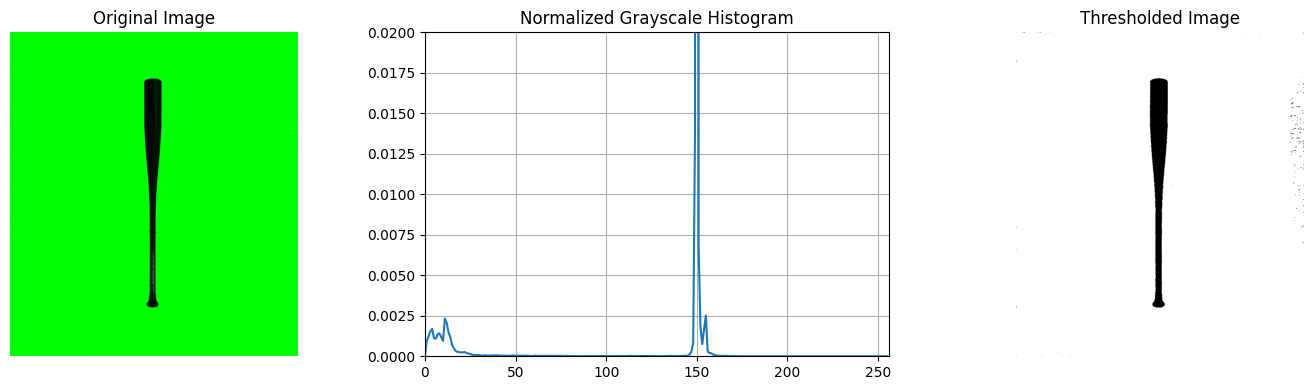

In [41]:
def threshold(t1, t2, img):
    th_img = img.copy()
    th_img[th_img < t1] = 0
    th_img[th_img > t2] = 0
    th_img[th_img != 0] = 255
    return th_img

# Outputing Histogram for input image(s)
def display_histogram(img_path):
  img_wdg = cv2.imread(img_path)
  img_gray = cv2.cvtColor(img_wdg, cv2.COLOR_BGR2GRAY)
  # plt.imshow(img_wdg);
  # plt.hist(img_wdg.ravel(), 256, [0,256])
  # plt.grid();

  # figure with 3 subplots
  plt.figure(figsize=(15, 4))

  # Show the original image in the first subplot
  plt.subplot(1, 3, 1)
  plt.imshow(cv2.cvtColor(img_wdg, cv2.COLOR_BGR2RGB))  # Show the image in RGB
  plt.title('Original Image')
  plt.axis('off')  # Hide axes for image
  # Show the histogram in the second subplot
  plt.subplot(1, 3, 2)
  # Calculate the histogram and normalize it
  hist, bins = np.histogram(img_gray.ravel(), 256, [0, 256])
  hist = hist / hist.sum()  # Normalize the histogram

  plt.plot(hist)
  plt.title('Normalized Grayscale Histogram')
  plt.xlim([0, 256])  # Set x-axis range for pixel values
  plt.ylim([0, 0.02])  # Set y-axis range from 0 to 0.02
  plt.grid(True)
  # plt.hist(img_gray.ravel(), 256, [0, 256])
  # plt.title('Grayscale Histogram')
  # plt.grid(True)

  img_after_thresholding = threshold(140, 155, img_gray)
  plt.subplot(1, 3, 3)  # Third subplot
  plt.imshow(img_after_thresholding, cmap='gray')  # Show the thresholded image
  plt.title('Thresholded Image')
  plt.axis('off')  # Hide axes for the image

  # Show the plots
  plt.tight_layout()
  plt.show()




display_histogram(images[-1])





#Approach 2: K-Means Clustering Technique

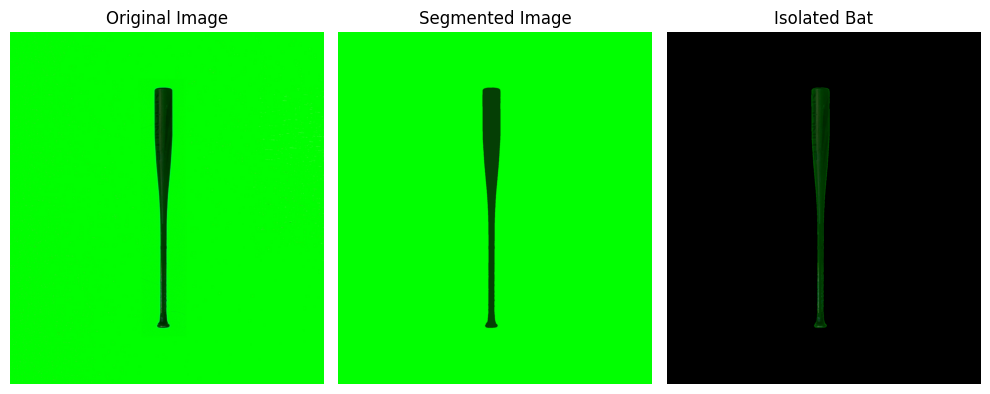

In [94]:
img = cv2.imread(images[-1])

# Convert the image to RGB (from BGR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# reshape the image into a 2D array of pixels
pixel_values = img_rgb.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# define the criteria and apply KMeans
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2  # divide the image into 2 clusters (bat and background)
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert the centers (which are floats) back to 8-bit values
centers = np.uint8(centers)

# map the labels to their respective pixel values
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(img_rgb.shape)

labels_reshape = labels.reshape(img_rgb.shape[0], img_rgb.shape[1])

# Assume the background is the most common label
background_label = np.bincount(labels.flatten()).argmax()

# Create a mask where the background is 0 and the bat is 1
mask = np.where(labels_reshape == background_label, 0, 1)

# Apply the mask to the original image to isolate the bat
bat_only = img_rgb * mask[:, :, np.newaxis]

# Display the original and the segmented image side by side
plt.figure(figsize=(10, 5))

# segmented_image_gray = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)

plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bat_only)
plt.title('Isolated Bat')
plt.axis('off')

plt.tight_layout()
plt.show()


GOT HERE1!!!


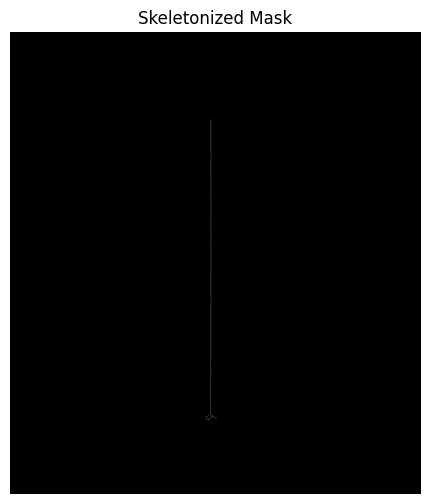

GOT HERE2!!!
GOT HERE3!!!
GOT HERE4!!!
GOT HERE5!!!
GOT HERE!!!


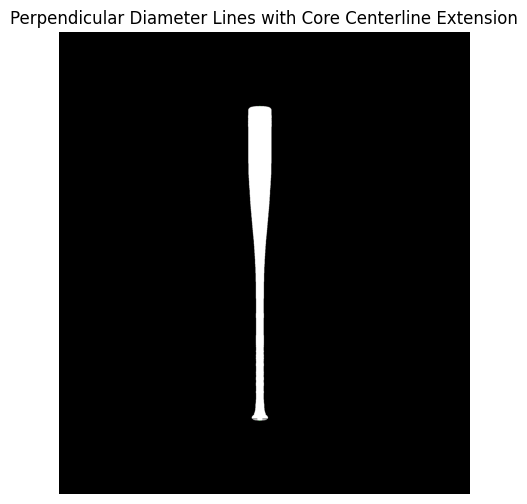

bat length: 1531
number of diameters measured: 1531
below is diameter:
[42, 60, 70, 80, 86, 92, 94, 98, 100, 102, 104, 106, 108, 108, 110, 110, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 114, 114, 112, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 112, 112, 112, 112, 114, 114, 114, 114, 112, 114, 114, 112, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 112, 112, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 1

In [95]:
"""
Usage notes: the following method requires a very robust, noise-less segmentation solution as the pre-req!
"""

# import skimage function that automates centerline detection
from skimage.morphology import skeletonize

# Helper function; Identifies a core section for the centerline to be used for centerline extension
# Args:
  # x_coords, y_coords: the coordinates that represent the OG centerline (detected by skeletonize)
  # core_size: the core section size; dependent on the image formation; for example, if the bat is far from the lens (and thus smaller in the image), core section size could be smaller
def get_core_centerline(y_coords, x_coords, core_size=10):

    # Find the center index
    center_index = len(x_coords) // 2

    # Select 10 pixels on either side of the center
    start_index = max(center_index - core_size, 0)
    end_index = min(center_index + core_size, len(x_coords) - 1)

    core_x_coords = x_coords[start_index:end_index + 1]
    core_y_coords = y_coords[start_index:end_index + 1]

    return core_y_coords, core_x_coords

# Helper function; extends the core centerline that's identified in the function above
def extend_core_centerline(core_y_coords, core_x_coords, mask):

    # Get the starting and ending points of the core centerline
    y_start, x_start = core_y_coords[0], core_x_coords[0]
    y_end, x_end = core_y_coords[-1], core_x_coords[-1]

    # Calculate & normal  ize the direction
    dx = np.mean(np.diff(core_x_coords))
    dy = np.mean(np.diff(core_y_coords))
    norm = np.sqrt(dx**2 + dy**2)
    dir_x = dx / norm
    dir_y = dy / norm

    # Extend the centerline in both directions
    extended_x_coords = list(core_x_coords)
    extended_y_coords = list(core_y_coords)

    centerline_length = len(core_x_coords)  # init a length variable to measure the extended centerline

    # extending beyong start
    while True:
        new_x = int(x_start - dir_x)
        new_y = int(y_start - dir_y)
        if 0 <= new_x < mask.shape[1] and 0 <= new_y < mask.shape[0] and mask[new_y, new_x] != 0:
            extended_x_coords.insert(0, new_x)
            extended_y_coords.insert(0, new_y)
            x_start, y_start = new_x, new_y
            centerline_length += 1
        else:
            break  # extension stops at segmentation boundary

    # extending beyong ending point
    while True:
        new_x = int(x_end + dir_x)
        new_y = int(y_end + dir_y)
        if 0 <= new_x < mask.shape[1] and 0 <= new_y < mask.shape[0] and mask[new_y, new_x] != 0:
            extended_x_coords.append(new_x)
            extended_y_coords.append(new_y)
            x_end, y_end = new_x, new_y
            centerline_length += 1
        else:
            break  # extension stops at segmentation boundary

    return extended_y_coords, extended_x_coords, centerline_length

"""Test section begins"""

"""Test section ends"""

# main function to reconstruct diameters at every point along the centerline
def calc_diameters(image, mask, core_size=10):

    # make sure the mask (calculated in the last step) is valid
    mask = (mask > 0).astype(np.uint8)

    print("SUCCESS: stage 1 - segmentation mask validation")

    # skimage function that automates centerline detection
    skeleton = skeletonize(mask).astype(np.uint8)
    plt.figure(figsize=(6, 6))
    plt.imshow(skeleton, cmap='gray')  # Show the skeleton in grayscale
    plt.title("Skeletonized Mask")
    plt.axis('off')  # Optional: hide axis for a cleaner view
    plt.show()
    print("SUCCESS: stage 2 - skeletonize segmentation")

    # get centerline and extend it using the 2 helper functions defined above
    y_coords, x_coords = np.where(skeleton > 0)

    core_y_coords, core_x_coords = get_core_centerline(y_coords, x_coords, core_size)
    print("SUCCESS: stage 3 - centerline attained")
    y_coords_ext, x_coords_ext, bat_length = extend_core_centerline(core_y_coords, core_x_coords, mask)
    print("SUCCESS: stage 4 - extend centerline to represent the bat's length")


    canvas = np.zeros_like(image)  # create blank canvas (same size as input img)

    #  -------- BELOW IS FOR TESTING ONLY!!! DO NOT ENABLE!!!  --------

    # draw the extended centerline on blank canvas
    for i in range(len(x_coords_ext)):
        cv2.circle(canvas, (x_coords_ext[i], y_coords_ext[i]), 1, (0, 255, 0), 2)  # Green centerline

    #  ------------------------ Testing section ends------------------------


    diameters = []

    for idx in range(len(x_coords_ext)):
        # get the centerline point
        y_center = y_coords_ext[idx]
        x_center = x_coords_ext[idx]

        # calculate the perpendicular direction (estimate by gradient)
        if idx > 1 and idx < len(x_coords_ext) - 2:
            dy = y_coords_ext[idx + 1] - y_coords_ext[idx - 1]
            dx = x_coords_ext[idx + 1] - x_coords_ext[idx - 1]
        elif idx == 0:  # handle the first point by using the next point's gradient
            dy = y_coords_ext[idx + 1] - y_coords_ext[idx]
            dx = x_coords_ext[idx + 1] - x_coords_ext[idx]
        elif idx == len(x_coords_ext) - 1:  # handle the last point by using the previous point's gradient
            dy = y_coords_ext[idx] - y_coords_ext[idx - 1]
            dx = x_coords_ext[idx] - x_coords_ext[idx - 1]
        else:
            dy, dx = 1, 0  # default values for intermediate points

        # normalize  direction to find perpendicular vector
        norm = np.sqrt(dx**2 + dy**2)
        perp_dir_x = -dy / norm
        perp_dir_y = dx / norm

        # search for the bat's boundary along the perpendicular
        line_length = 0
        max_length = min(image.shape[0], image.shape[1])  # search scope must be within image frame
        for length in range(max_length):
            x_left = int(x_center + perp_dir_x * (-length))
            y_left = int(y_center + perp_dir_y * (-length))
            x_right = int(x_center + perp_dir_x * length)
            y_right = int(y_center + perp_dir_y * length)

            # ensure the points are within the image bounds
            if (0 <= x_left < image.shape[1] and 0 <= y_left < image.shape[0]
                and mask[y_left, x_left] == 0):
                break
            if (0 <= x_right < image.shape[1] and 0 <= y_right < image.shape[0]
                and mask[y_right, x_right] == 0):
                break
            line_length = length

        # calculate diameter at the given point
        diameter = 2 * line_length

        # --------------- Note: the line below can be disabled if no visualization is needed! ---------------
        # draw the diameter line on the blank canvas
        cv2.line(canvas, (x_center - int(perp_dir_x * line_length),
                          y_center - int(perp_dir_y * line_length)),
                 (x_center + int(perp_dir_x * line_length),
                  y_center + int(perp_dir_y * line_length)),
                 (255, 255, 255), 1)  # Draw diameter lines in white (thickness = 1)


        # store the diameter in the diameters array
        diameters.append(diameter)

    return canvas, diameters, bat_length


# the previous code modular MUST generate a segmentation mask that's named "mask"
bat_mask = mask

# apply the function to draw perpendicular lines on a blank canvas with the core-based centerline
canvas_with_diameters, diameters, bat_length = calc_diameters(img_rgb, bat_mask, core_size=10)

# display the result
plt.figure(figsize=(10, 6))
plt.imshow(canvas_with_diameters)
plt.title("Perpendicular Diameter Lines with Core Centerline Extension")
plt.axis('off')
plt.show()

print("bat length:",bat_length)
print("number of diameters measured:",len(diameters))
print("below is diameter:")
print(diameters)


In [96]:

# default measurement unit: mm
def scale_diameters(diameters, bat_length_pixel, bat_length_actual, unit = 'mm'):
  # usage note: scaler * diameter_in_pixel = diameter_actual
  scaler = float(bat_length_actual) / float(bat_length_pixel)

  diameters_actual = []
  measurement_interval = scaler

  for diameter in diameters:
    diameters_actual.append(diameter * scaler)

  return diameters_actual, measurement_interval

diameters_actual, measurement_interval = scale_diameters(diameters, bat_length, 863.60)
print(diameters_actual)
print("measurement interval:", measurement_interval, "mm")


[23.6911822338341, 33.84454604833442, 39.48530372305683, 45.12606139777923, 48.510516002612675, 51.89497060744612, 53.0231221423906, 55.27942521227956, 56.40757674722404, 57.53572828216852, 58.663879817113006, 59.792031352057485, 60.920182887001964, 60.920182887001964, 62.04833442194644, 62.04833442194644, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 63.17648595689093, 64.30463749183541, 64.30463749183541, 63.17648595689093, 64.30463749183541, 64.30463749183541, 64.30463749183541, 64.30463749183541, 64.30463749183541, 64.30463

#Approach 3: Canny Edge Detector

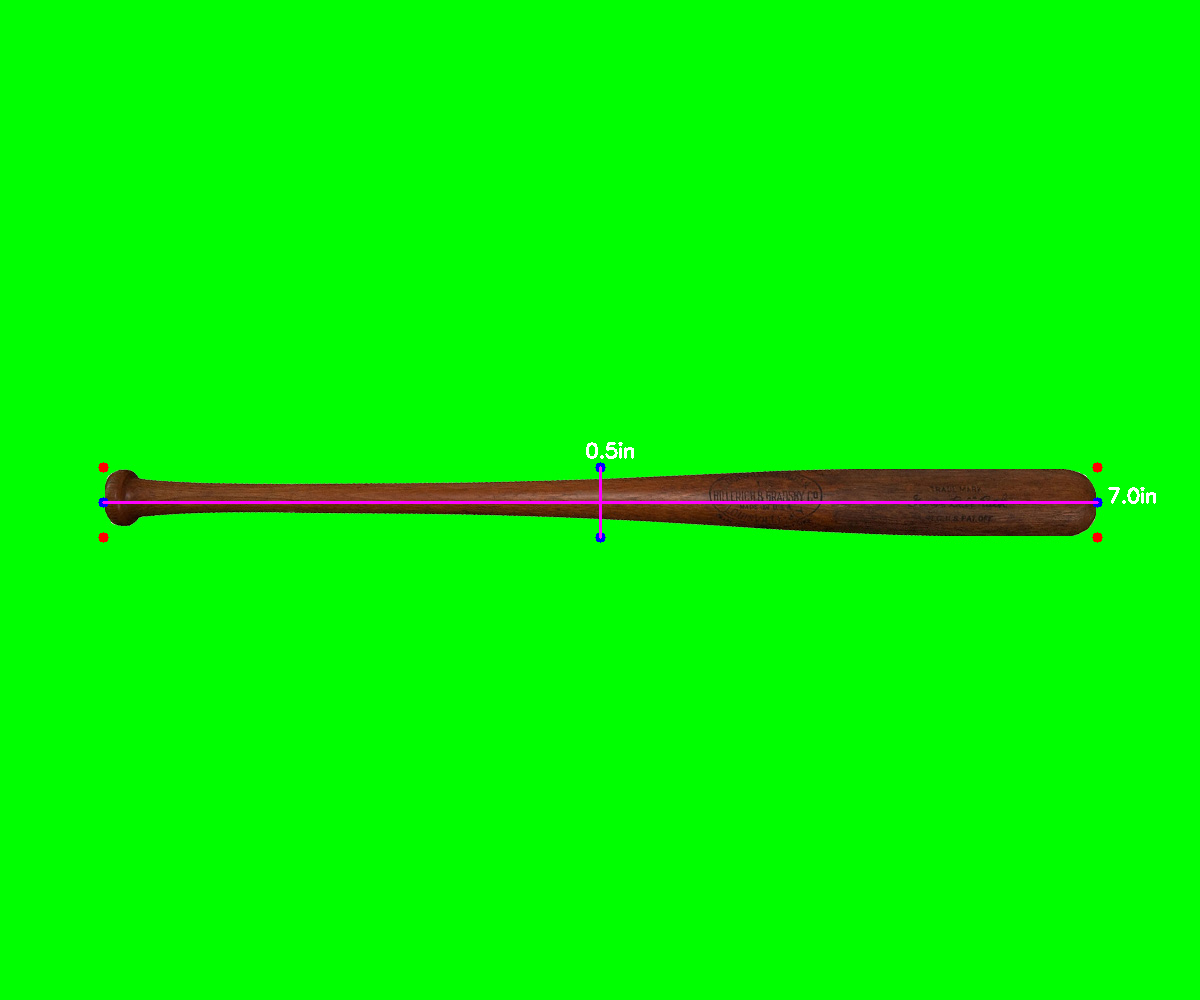

-1

In [ ]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

# construct the argument parse and parse the arguments
# NOTE!!! for testing purposes, the following lines are disabled for now
"""
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to the input image")
ap.add_argument("-w", "--width", type=float, required=True,
	help="width of the left-most object in the image (in inches)")
args = vars(ap.parse_args())
"""
temp_width = 7.0


# load the image, convert it to grayscale, and blur it slightly
# image = cv2.imread(args["image"])
image = cv2.imread(images[2])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

# loop over the contours individually
for c in cnts:
	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue

	# compute the rotated bounding box of the contour
	orig = image.copy()
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")

	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
	box = perspective.order_points(box)
	cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

	# loop over the original points and draw them

	for (x, y) in box:
		cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
	# unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
	(tl, tr, br, bl) = box
	(tltrX, tltrY) = midpoint(tl, tr)
	(blbrX, blbrY) = midpoint(bl, br)
	# compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right

	(tlblX, tlblY) = midpoint(tl, bl)
	(trbrX, trbrY) = midpoint(tr, br)
	# draw the midpoints on the image
	cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
	# draw lines between the midpoints
	cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
        (255, 0, 255), 2)
	cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
        (255, 0, 255), 2)

	# compute the Euclidean distance between the midpoints
	dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
	dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

	# if the pixels per metric has not been initialized, then
	# compute it as the ratio of pixels to supplied metric
	# (in this case, inches)
	if pixelsPerMetric is None:
		pixelsPerMetric = dB / temp_width
    #replace the above "temp_width" with args["width"] later!

    # compute the size of the object
	dimA = dA / pixelsPerMetric
	dimB = dB / pixelsPerMetric

	# draw the object sizes on the image
	cv2.putText(orig, "{:.1f}in".format(dimA),
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	cv2.putText(orig, "{:.1f}in".format(dimB),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)

	# show the output image
	# cv2.imshow("Image", orig)
cv2_imshow(orig)
cv2.waitKey(0)